In [137]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [138]:
data1 = pd.read_excel("test.xlsm", sheet_name='HPB4 Formula')
data2 = pd.read_excel("test.xlsm", sheet_name='HPB5 Formula')
data3 = pd.read_excel("test.xlsm", sheet_name='ABI Formula')

In [139]:
def preprocess_scheduling_data(df, name):
    print(f'\n=== Processing {name} ===')
    print(f'Original shape: {df.shape}')
    
    # Keep only important columns first
    important_cols = ['Start Date', 'Completion Date', 'Forecast \nStart date', 'Forecast \nEnd date',
                     'Quantity', 'FT & Debug Time between Rdpts', 'Adjusted Window (days)',
                     'Actual Duration (adjusted hrs)', 'Readpoint Duration', 'Sockets per BIB',
                     'DUT Loading Capacity', 'Slots Use', 'System Config', 'Tray Type']
    
    # Select only columns that exist in the dataframe
    existing_cols = [col for col in important_cols if col in df.columns]
    processed = df[existing_cols].copy()
    
    # Remove rows with NaN in important columns
    processed = processed.dropna()
    print(f'After keeping important columns and removing NaN rows: {processed.shape}')
    
    # 1. DateTime features - specific columns
    datetime_cols = ['Start Date', 'Completion Date', 'Forecast \nStart date', 'Forecast \nEnd date']
    
    for col in datetime_cols:
        if col in processed.columns:
            processed[col] = pd.to_datetime(processed[col], errors='coerce')
    
    # Extract features from Start Date
    if 'Start Date' in processed.columns:
        processed['day_of_week'] = processed['Start Date'].dt.dayofweek
        processed['is_weekend'] = (processed['Start Date'].dt.dayofweek >= 5).astype(int)
    
    # Calculate duration
    if 'Start Date' in processed.columns and 'Completion Date' in processed.columns:
        processed['total_duration_hours'] = (processed['Completion Date'] - processed['Start Date']).dt.total_seconds() / 3600
    
    # 2. Normalize quantitative features
    scaler = StandardScaler()
    quant_cols = ['Quantity', 'FT & Debug Time between Rdpts', 'Adjusted Window (days)', 
                  'Actual Duration (adjusted hrs)', 'Readpoint Duration', 'Sockets per BIB', 
                  'DUT Loading Capacity', 'Slots Use']
    
    for col in quant_cols:
        if col in processed.columns:
            processed[f'{col}_norm'] = scaler.fit_transform(processed[[col]].fillna(0))
    
    # 3. Engineer conflict features
    if 'Quantity' in processed.columns and 'DUT Loading Capacity' in processed.columns:
        processed['utilization'] = processed['Quantity'] / (processed['DUT Loading Capacity'] + 1e-6)
    if 'Sockets per BIB' in processed.columns and 'Actual Duration (adjusted hrs)' in processed.columns:
        processed['load_score'] = processed['Sockets per BIB'] * processed['Actual Duration (adjusted hrs)']
    if 'Slots Use' in processed.columns and 'Quantity' in processed.columns and 'DUT Loading Capacity' in processed.columns:
        processed['overlap_risk_score'] = (processed['Slots Use'] * processed['Quantity']) / (processed['DUT Loading Capacity'] + 1e-6)
    
    # 4. One-hot encode Tray Type and System Config
    cat_cols = ['Tray Type', 'System Config']
    for col in cat_cols:
        if col in processed.columns:
            dummies = pd.get_dummies(processed[col], prefix=col, dummy_na=True)
            processed = pd.concat([processed, dummies], axis=1)
    
    # Drop original categorical columns after encoding
    processed = processed.drop(['Tray Type', 'System Config'], axis=1, errors='ignore')
    
    # 5. Select final features
    final_cols = []
    for col in processed.columns:
        if (isinstance(col, str) and col.endswith('_norm')) or \
           col in ['day_of_week', 'is_weekend', 'total_duration_hours', 'utilization', 'load_score', 'overlap_risk_score'] or\
           any(cat in str(col) for cat in cat_cols):
            final_cols.append(col)
    
    final_df = processed[final_cols].fillna(0)
    print(f'Final shape: {final_df.shape}')
    print(f'Features: {final_cols[:10]}...' if len(final_cols) > 10 else f'Features: {final_cols}')
    print(final_df.head(2))
    
    return final_df

In [140]:
# Process all datasets
processed_data1 = preprocess_scheduling_data(data1, 'HPB4 Formula')
processed_data2 = preprocess_scheduling_data(data2, 'HPB5 Formula')
processed_data3 = preprocess_scheduling_data(data3, 'ABI Formula')

# Check column differences
print('\n=== Column Analysis ===')
print(f'Data1 columns: {set(processed_data1.columns)}')
print(f'Data2 columns: {set(processed_data2.columns)}')
print(f'Data3 columns: {set(processed_data3.columns)}')

print('\nMissing columns:')
print(f'Data1 missing: {set(processed_data2.columns) | set(processed_data3.columns) - set(processed_data1.columns)}')
print(f'Data2 missing: {set(processed_data1.columns) | set(processed_data3.columns) - set(processed_data2.columns)}')
print(f'Data3 missing: {set(processed_data1.columns) | set(processed_data2.columns) - set(processed_data3.columns)}')

# Align columns across datasets
all_columns = set(processed_data1.columns) | set(processed_data2.columns) | set(processed_data3.columns)

for df in [processed_data1, processed_data2, processed_data3]:
    for col in all_columns:
        if col not in df.columns:
            df[col] = 0

sorted_cols = sorted(all_columns)
processed_data1 = processed_data1[sorted_cols]
processed_data2 = processed_data2[sorted_cols]
processed_data3 = processed_data3[sorted_cols]

# Combine datasets
all_data = pd.concat([processed_data1, processed_data2, processed_data3], ignore_index=True)
print(f'\nCombined dataset shape: {all_data.shape}')
print(f'NaN values: {all_data.isnull().sum().sum()}')


=== Processing HPB4 Formula ===
Original shape: (601, 1156)
After keeping important columns and removing NaN rows: (421, 11)
Final shape: (421, 13)
Features: ['day_of_week', 'is_weekend', 'total_duration_hours', 'Quantity_norm', 'FT & Debug Time between Rdpts_norm', 'Readpoint Duration_norm', 'Sockets per BIB_norm', 'Slots Use_norm', 'Tray Type_HFTT', 'Tray Type_Std TT']...
   day_of_week  is_weekend  total_duration_hours  Quantity_norm  \
0            0           0                4392.0       -0.15082   
1            0           0                4392.0       -0.15082   

   FT & Debug Time between Rdpts_norm  Readpoint Duration_norm  \
0                            0.128491                -0.481468   
1                            0.128491                 0.136875   

   Sockets per BIB_norm  Slots Use_norm  Tray Type_HFTT  Tray Type_Std TT  \
0               1.72073       -1.381095               0                 1   
1               1.72073       -1.381095               0            

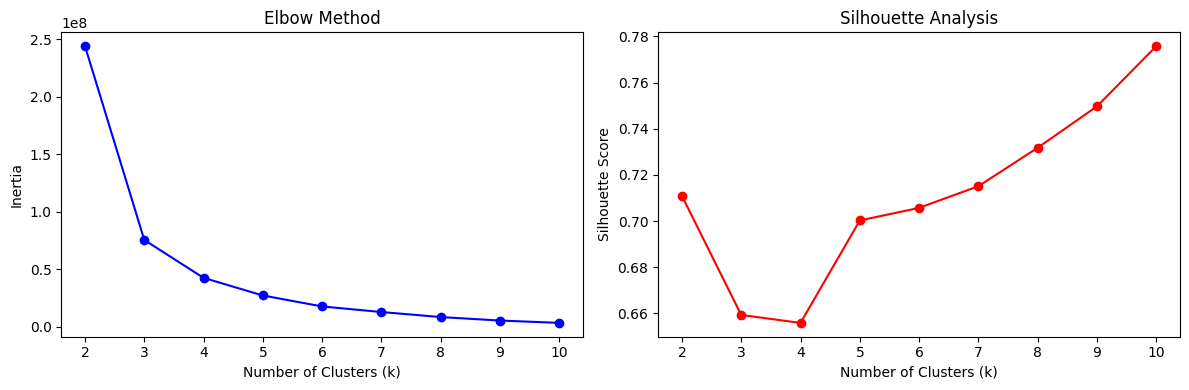

Optimal clusters: 10


In [141]:
def find_optimal_clusters(data, max_k=10):
    inertias = []
    silhouette_scores = []
    k_range = range(2, max_k + 1)
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(data)
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(data, labels))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.plot(k_range, inertias, 'bo-')
    ax1.set_xlabel('Number of Clusters (k)')
    ax1.set_ylabel('Inertia')
    ax1.set_title('Elbow Method')
    
    ax2.plot(k_range, silhouette_scores, 'ro-')
    ax2.set_xlabel('Number of Clusters (k)')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title('Silhouette Analysis')
    
    plt.tight_layout()
    plt.show()
    
    optimal_k = k_range[np.argmax(silhouette_scores)]
    print(f'Optimal clusters: {optimal_k}')
    return optimal_k

optimal_k = find_optimal_clusters(all_data)

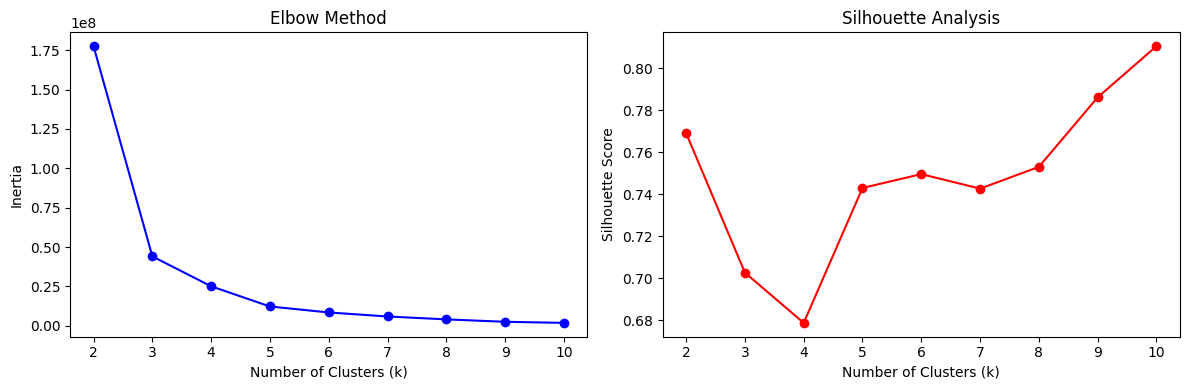

Optimal clusters: 10
K-Means clusters: 10
DBSCAN clusters: 15 (plus 304 noise)

K-Means distribution:
0     22
1    137
2     14
3     62
4     53
5     10
6      7
7     53
8     27
9     36
dtype: int64


In [153]:

optimal_k_1 = find_optimal_clusters(processed_data1)
# K-Means clustering
kmeans = KMeans(n_clusters=optimal_k_1, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(processed_data1)

# DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(processed_data1)

processed_data1['kmeans_cluster'] = kmeans_labels
processed_data1['dbscan_cluster'] = dbscan_labels

print(f'K-Means clusters: {len(np.unique(kmeans_labels))}')
print(f'DBSCAN clusters: {len(np.unique(dbscan_labels[dbscan_labels != -1]))} (plus {sum(dbscan_labels == -1)} noise)')
print('\nK-Means distribution:')
print(pd.Series(kmeans_labels).value_counts().sort_index())

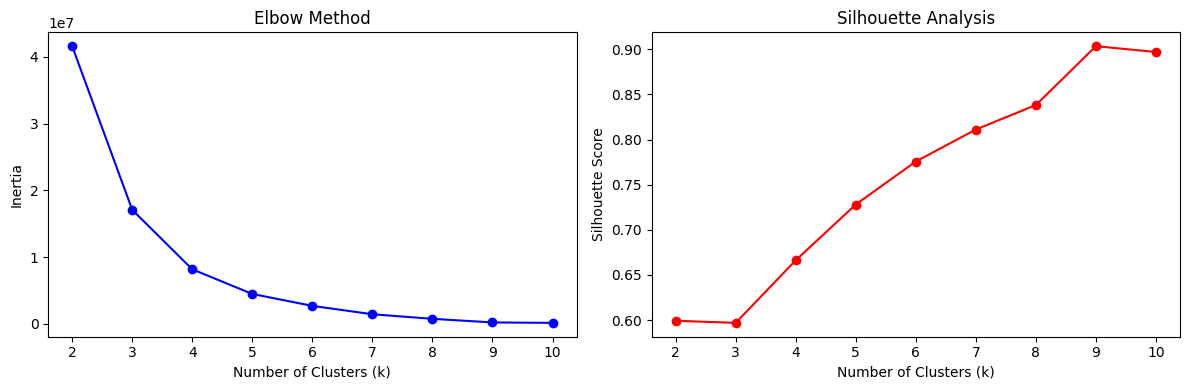

Optimal clusters: 9
K-Means clusters: 9
DBSCAN clusters: 2 (plus 95 noise)

K-Means distribution:
0    10
1    16
2    15
3    22
4     9
5    13
6     4
7     6
8    12
dtype: int64


In [154]:

optimal_k_2 = find_optimal_clusters(processed_data2)
# K-Means clustering
kmeans = KMeans(n_clusters=optimal_k_2, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(processed_data2)

# DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(processed_data2)

processed_data2['kmeans_cluster'] = kmeans_labels
processed_data2['dbscan_cluster'] = dbscan_labels

print(f'K-Means clusters: {len(np.unique(kmeans_labels))}')
print(f'DBSCAN clusters: {len(np.unique(dbscan_labels[dbscan_labels != -1]))} (plus {sum(dbscan_labels == -1)} noise)')
print('\nK-Means distribution:')
print(pd.Series(kmeans_labels).value_counts().sort_index())

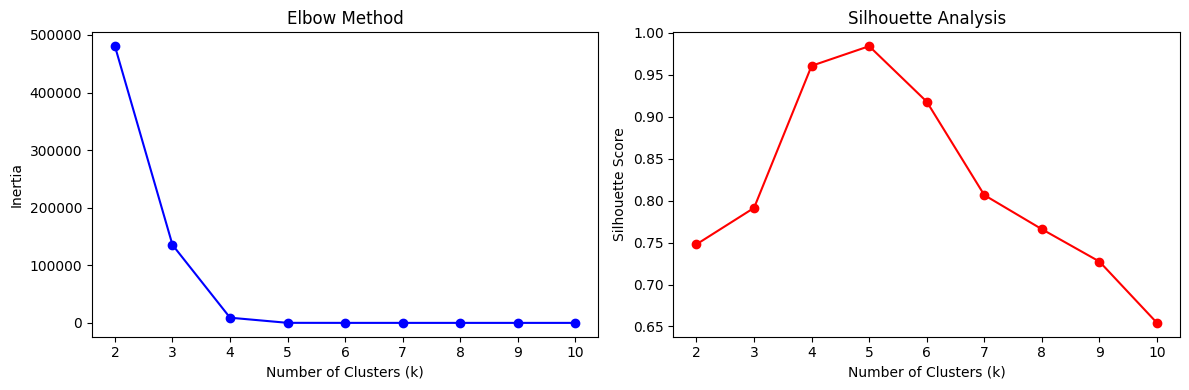

Optimal clusters: 5
K-Means clusters: 5
DBSCAN clusters: 0 (plus 24 noise)

K-Means distribution:
0    6
1    4
2    8
3    3
4    3
dtype: int64


C:\Users\Rald999\AppData\Local\Temp\ipykernel_24816\2033090532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_data3['kmeans_cluster'] = kmeans_labels
C:\Users\Rald999\AppData\Local\Temp\ipykernel_24816\2033090532.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_data3['dbscan_cluster'] = dbscan_labels


In [155]:

optimal_k_3 = find_optimal_clusters(processed_data3)
# K-Means clustering
kmeans = KMeans(n_clusters=optimal_k_3, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(processed_data3)

# DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(processed_data3)

processed_data3['kmeans_cluster'] = kmeans_labels
processed_data3['dbscan_cluster'] = dbscan_labels

print(f'K-Means clusters: {len(np.unique(kmeans_labels))}')
print(f'DBSCAN clusters: {len(np.unique(dbscan_labels[dbscan_labels != -1]))} (plus {sum(dbscan_labels == -1)} noise)')
print('\nK-Means distribution:')
print(pd.Series(kmeans_labels).value_counts().sort_index())

In [142]:
# K-Means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(all_data)

# DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(all_data)

all_data['kmeans_cluster'] = kmeans_labels
all_data['dbscan_cluster'] = dbscan_labels

print(f'K-Means clusters: {len(np.unique(kmeans_labels))}')
print(f'DBSCAN clusters: {len(np.unique(dbscan_labels[dbscan_labels != -1]))} (plus {sum(dbscan_labels == -1)} noise)')
print('\nK-Means distribution:')
print(pd.Series(kmeans_labels).value_counts().sort_index())

K-Means clusters: 10
DBSCAN clusters: 17 (plus 423 noise)

K-Means distribution:
0     86
1     18
2     66
3     91
4    155
5     10
6     57
7     16
8     43
9     10
dtype: int64


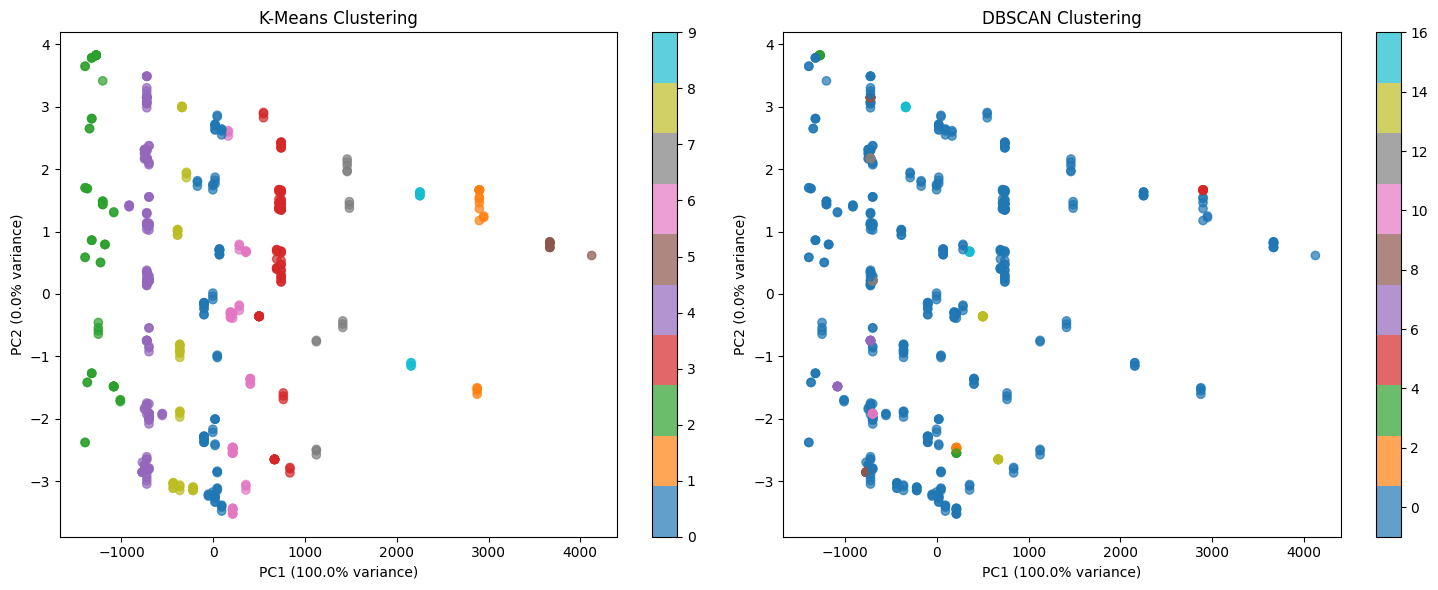

In [143]:
# Use PCA to reduce dimensions for visualization
pca = PCA(n_components=2)
data_2d = pca.fit_transform(all_data.drop(['kmeans_cluster', 'dbscan_cluster'], axis=1))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# K-Means scatter plot
scatter1 = ax1.scatter(data_2d[:, 0], data_2d[:, 1], c=kmeans_labels, cmap='tab10', alpha=0.7)
ax1.set_title('K-Means Clustering')
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.colorbar(scatter1, ax=ax1)

# DBSCAN scatter plot
scatter2 = ax2.scatter(data_2d[:, 0], data_2d[:, 1], c=dbscan_labels, cmap='tab10', alpha=0.7)
ax2.set_title('DBSCAN Clustering')
ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.colorbar(scatter2, ax=ax2)

plt.tight_layout()
plt.show()

In [144]:
# Save results
all_data.to_csv('clustered_scheduling_data.csv', index=False)
print('Clustering complete! Results saved to clustered_scheduling_data.csv')
print(f'Total records: {len(all_data)}')
print(f'Features used: {len(all_data.columns) - 2}')

Clustering complete! Results saved to clustered_scheduling_data.csv
Total records: 552
Features used: 17


In [145]:
mehmeh = pd.read_csv("clustered_scheduling_data.csv")
mehmeh

,FT & Debug Time between Rdpts_norm,Quantity_norm,Readpoint Duration_norm,Slots Use_norm,Sockets per BIB_norm,System Config_ABI,System Config_HPB4,System Config_HPB5,System Config_nan,Tray Type_ABI,Tray Type_HFTT,Tray Type_HPB5C,Tray Type_Std TT,Tray Type_nan,day_of_week,is_weekend,total_duration_hours,kmeans_cluster,dbscan_cluster
0,0.128491,-0.150820,-0.481468,-1.381095,1.720730,0,1,0,0,0,0,0,1,0,0,0,4392.0,1,-1
1,0.128491,-0.150820,0.136875,-1.381095,1.720730,0,1,0,0,0,0,0,1,0,0,0,4392.0,1,-1
2,-0.774968,-0.516862,-0.718500,-1.180169,0.606226,0,1,0,0,0,0,0,1,0,5,1,1344.0,0,0
3,-0.774968,-0.516862,-0.481468,-1.180169,0.606226,0,1,0,0,0,0,0,1,0,5,1,1344.0,0,0
4,-0.774968,-0.516862,0.136875,-1.180169,0.606226,0,1,0,0,0,0,0,1,0,5,1,1344.0,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547,0.000000,-1.067490,1.489933,-1.056443,0.000000,1,0,0,0,1,0,0,0,0,0,0,1536.0,0,-1
548,0.000000,-1.067490,-1.064604,-1.056443,0.000000,1,0,0,0,1,0,0,0,0,6,1,1536.0,0,-1
549,0.000000,-1.067490,-0.823996,-1.056443,0.000000,1,0,0,0,1,0,0,0,0,6,1,1536.0,0,-1
550,0.000000,-1.067490,-0.209679,-1.056443,0.000000,1,0,0,0,1,0,0,0,0,6,1,1536.0,0,-1


In [148]:
mehmeh.columns

Index(['FT & Debug Time between Rdpts_norm', 'Quantity_norm',
       'Readpoint Duration_norm', 'Slots Use_norm', 'Sockets per BIB_norm',
       'System Config_ABI', 'System Config_HPB4', 'System Config_HPB5',
       'System Config_nan', 'Tray Type_ABI', 'Tray Type_HFTT',
       'Tray Type_HPB5C', 'Tray Type_Std TT', 'Tray Type_nan', 'day_of_week',
       'is_weekend', 'total_duration_hours', 'kmeans_cluster',
       'dbscan_cluster'],
      dtype='object')

📊 Cluster Summary (Normalized Numeric Features):


FT & Debug Time between Rdpts_norm       Quantity_norm        \
                                             mean   std          mean   std   
kmeans_cluster                                                                
0                                           -0.14  0.73         -0.20  0.96   
1                                           -1.41  1.05          1.46  1.35   
2                                           -0.45  1.05          0.83  1.19   
3                                            0.48  0.78         -0.21  0.61   
4                                            0.07  0.99         -0.13  0.85   
5                                            0.08  0.14         -0.54  0.18   
6                                            0.10  0.05         -0.45  0.63   
7                                            0.23  0.49          1.33  1.38   
8                                            0.07  0.06         -0.39  0.51   
9                                            0.00  0.00          0.13  0.34   

               Readpoint Duration_norm       Slots Use_norm        \
                                  mean   std           mean   std   
kmeans_cluster                                                      
0                                 0.27  1.15          -0.55  0.72   
1                                 0.73  2.57          -0.05  0.49   
2                                -0.46  0.47           0.88  1.11   
3                                -0.24  0.72          -0.14  1.29   
4                                -0.18  0.69           0.00  0.76   
5                                 0.38  1.05          -1.14  0.39   
6                                 0.35  1.01          -0.30  0.76   
7                                 0.36  1.07           0.66  1.41   
8                                 0.17  0.99           0.42  0.46   
9                                 0.71  1.05           0.24  0.20   

               Sockets per BIB_norm       day_of_week       is_weekend        \
                               mean   std        mean   std       mean   std   
kmeans_cluster                                                                 
0                              0.27  0.94        3.48  2.17       0.47  0.50   
1                              1.58  0.28        0.67  1.28       0.00  0.00   
2                             -0.11  1.24        2.45  1.99       0.26  0.44   
3                              0.10  0.98        2.02  1.53       0.13  0.34   
4                             -0.02  0.97        3.08  2.05       0.34  0.48   
5                              0.44  0.53        0.00  0.00       0.00  0.00   
6                             -0.39  0.44        3.95  1.68       0.47  0.50   
7                              0.26  0.88        2.06  1.91       0.19  0.40   
8                             -0.63  0.36        3.74  2.23       0.44  0.50   
9                             -0.95  0.00        1.20  1.55       0.00  0.00   

               total_duration_hours          
                               mean     std  
kmeans_cluster                               
0                           1436.09   72.78  
1                           4344.00   20.16  
2                            189.82  108.87  
3                           2133.36   89.83  
4                            721.55   43.30  
5                           5157.60  144.20  
6                           1701.47   76.93  
7                           2794.50  159.43  
8                           1095.07   63.29  
9                           3657.60   49.57


📌 System Config_ABI (proportion of rows in each cluster = 1):


kmeans_cluster
0    0.09
1    0.00
2    0.00
3    0.03
4    0.00
5    0.00
6    0.11
7    0.00
8    0.16
9    0.00
Name: System Config_ABI, dtype: float64


📌 System Config_HPB4 (proportion of rows in each cluster = 1):


kmeans_cluster
0    0.72
1    0.78
2    0.80
3    0.73
4    0.90
5    1.00
6    0.79
7    0.44
8    0.56
9    0.00
Name: System Config_HPB4, dtype: float64


📌 System Config_HPB5 (proportion of rows in each cluster = 1):


kmeans_cluster
0    0.19
1    0.22
2    0.20
3    0.24
4    0.10
5    0.00
6    0.11
7    0.56
8    0.28
9    1.00
Name: System Config_HPB5, dtype: float64


📌 Tray Type_ABI (proportion of rows in each cluster = 1):


kmeans_cluster
0    0.09
1    0.00
2    0.00
3    0.03
4    0.00
5    0.00
6    0.11
7    0.00
8    0.16
9    0.00
Name: Tray Type_ABI, dtype: float64


📌 Tray Type_HFTT (proportion of rows in each cluster = 1):


kmeans_cluster
0    0.24
1    0.00
2    0.58
3    0.23
4    0.65
5    0.00
6    0.68
7    0.19
8    0.56
9    0.00
Name: Tray Type_HFTT, dtype: float64


📌 Tray Type_HPB5C (proportion of rows in each cluster = 1):


kmeans_cluster
0    0.19
1    0.22
2    0.20
3    0.24
4    0.10
5    0.00
6    0.11
7    0.56
8    0.28
9    1.00
Name: Tray Type_HPB5C, dtype: float64


📌 Tray Type_Std TT (proportion of rows in each cluster = 1):


kmeans_cluster
0    0.48
1    0.78
2    0.23
3    0.49
4    0.25
5    1.00
6    0.11
7    0.25
8    0.00
9    0.00
Name: Tray Type_Std TT, dtype: float64

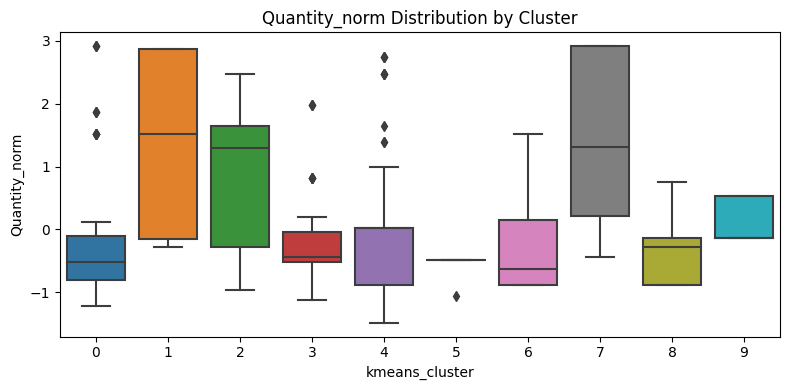

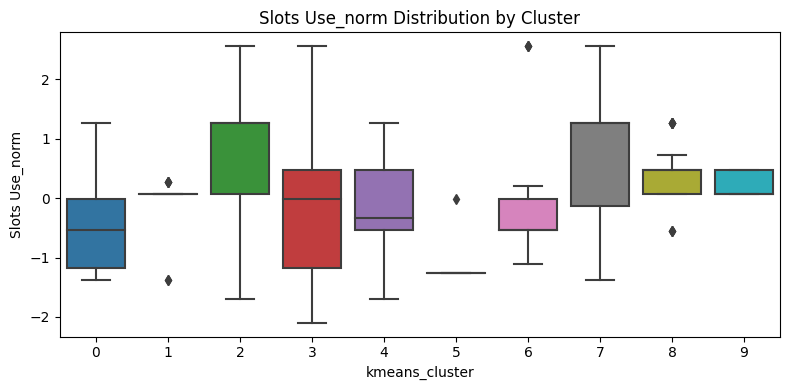

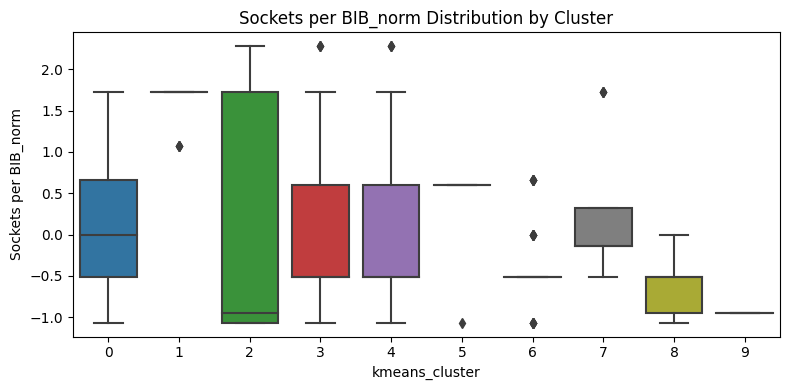

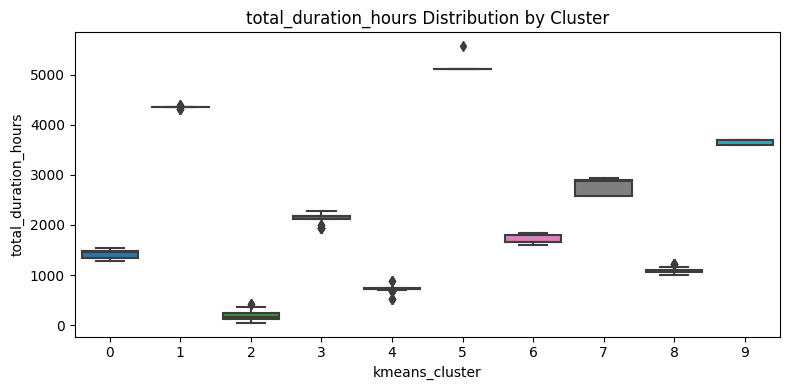

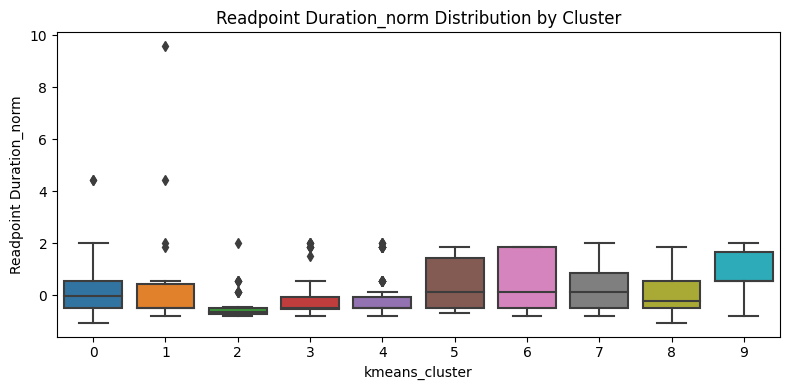

In [151]:
import seaborn as sns
import matplotlib.pyplot as plt

# Choose clustering label
cluster_label = 'kmeans_cluster'  # or 'dbscan_cluster'

# 1. Group and summarize normalized numeric features
numeric_features = [
    'FT & Debug Time between Rdpts_norm', 'Quantity_norm',
    'Readpoint Duration_norm', 'Slots Use_norm', 'Sockets per BIB_norm',
    'day_of_week', 'is_weekend', 'total_duration_hours'
]

print("📊 Cluster Summary (Normalized Numeric Features):")
display(
    mehmeh.groupby(cluster_label)[numeric_features].agg(['mean', 'std']).round(2)
)

# 2. Count proportion of encoded categorical features per cluster
encoded_cats = [
    'System Config_ABI', 'System Config_HPB4', 'System Config_HPB5',
    'Tray Type_ABI', 'Tray Type_HFTT', 'Tray Type_HPB5C',
    'Tray Type_Std TT'
]

for col in encoded_cats:
    cluster_props = mehmeh.groupby(cluster_label)[col].mean().round(2)
    print(f"\n📌 {col} (proportion of rows in each cluster = 1):")
    display(cluster_props)

# 3. Visualize distribution of key normalized features
key_plot_features = [
    'Quantity_norm', 'Slots Use_norm', 'Sockets per BIB_norm',
    'total_duration_hours', 'Readpoint Duration_norm'
]

for feature in key_plot_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=cluster_label, y=feature, data=mehmeh)
    plt.title(f'{feature} Distribution by Cluster')
    plt.tight_layout()
    plt.show()


In [146]:
def analyze_and_visualize_clusters(original_data, processed_data, dataset_name, n_clusters=5):
    # Perform clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(processed_data)
    
    # Add clusters to original data
    original_data = original_data.copy()
    original_data['cluster'] = cluster_labels
    
    # PCA for visualization
    pca = PCA(n_components=2)
    data_2d = pca.fit_transform(processed_data)
    
    # Create visualizations
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'Cluster Analysis - {dataset_name}', fontsize=16)
    
    # 1. PCA scatter plot
    scatter = axes[0,0].scatter(data_2d[:, 0], data_2d[:, 1], c=cluster_labels, cmap='tab10', alpha=0.7, s=50)
    axes[0,0].set_title('PCA Cluster Visualization')
    axes[0,0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    axes[0,0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    plt.colorbar(scatter, ax=axes[0,0])
    
    # 2-6. Boxplots for key features
    features = ['Quantity', 'Slots Use', 'FT & Debug Time between Rdpts', 'Sockets per BIB', 'total_duration_hours']
    positions = [(0,1), (0,2), (1,0), (1,1), (1,2)]
    
    for i, feature in enumerate(features):
        if feature in original_data.columns and i < len(positions):
            row, col = positions[i]
            original_data.boxplot(column=feature, by='cluster', ax=axes[row, col])
            axes[row, col].set_title(f'{feature} by Cluster')
            axes[row, col].set_xlabel('Cluster')
    
    plt.tight_layout()
    plt.show()
    
    # Generate cluster descriptions
    descriptions = {}
    conflict_risks = {}
    
    print(f'\n{"="*60}')
    print(f'CLUSTER ANALYSIS - {dataset_name}')
    print(f'{"="*60}')
    
    for cluster_id in range(n_clusters):
        cluster_data = original_data[original_data['cluster'] == cluster_id]
        
        # Calculate key metrics
        avg_quantity = cluster_data['Quantity'].mean() if 'Quantity' in cluster_data.columns else 0
        avg_slots = cluster_data['Slots Use'].mean() if 'Slots Use' in cluster_data.columns else 0
        avg_debug = cluster_data['FT & Debug Time between Rdpts'].mean() if 'FT & Debug Time between Rdpts' in cluster_data.columns else 0
        avg_duration = cluster_data['total_duration_hours'].mean() if 'total_duration_hours' in cluster_data.columns else 0
        weekend_pct = (cluster_data['Start Date'].dt.dayofweek >= 5).mean() * 100 if 'Start Date' in cluster_data.columns else 0
        
        # Categorize features
        quantity_cat = "high-quantity" if avg_quantity > 80 else "medium-quantity" if avg_quantity > 40 else "low-quantity"
        slots_cat = "heavy-slots" if avg_slots > 10 else "medium-slots" if avg_slots > 5 else "light-slots"
        debug_cat = "debug-heavy" if avg_debug > 150 else "standard-debug" if avg_debug > 100 else "light-debug"
        duration_cat = "long-duration" if avg_duration > 3000 else "medium-duration" if avg_duration > 1500 else "short-duration"
        timing_cat = "weekend-heavy" if weekend_pct > 30 else "weekday-focused"
        
        # Generate description
        description = f"{quantity_cat}, {duration_cat}, {slots_cat}, {debug_cat}, {timing_cat}"
        descriptions[cluster_id] = description
        
        # Assess conflict risk
        risk_score = 0
        if "heavy-slots" in slots_cat: risk_score += 3
        if "high-quantity" in quantity_cat: risk_score += 2
        if "debug-heavy" in debug_cat: risk_score += 1
        if "long-duration" in duration_cat: risk_score += 1
        
        if risk_score >= 4:
            conflict_risk = "HIGH CONFLICT RISK"
        elif risk_score >= 2:
            conflict_risk = "MEDIUM CONFLICT RISK"
        else:
            conflict_risk = "LOW CONFLICT RISK"
        
        conflict_risks[cluster_id] = conflict_risk
        
        # Print cluster summary
        print(f'\nCluster {cluster_id} ({len(cluster_data)} records):')
        print(f'  Description: {description}')
        print(f'  Conflict Risk: {conflict_risk}')
        print(f'  Key Stats: Qty={avg_quantity:.1f}, Slots={avg_slots:.1f}, Debug={avg_debug:.1f}h, Duration={avg_duration:.0f}h')
        print(f'  Weekend Jobs: {weekend_pct:.1f}%')
    
    return original_data, descriptions, conflict_risks

In [147]:
# Run analysis for all datasets
print('Processing HPB4 Formula...')
data1_clustered, desc1, risk1 = analyze_and_visualize_clusters(data1, processed_data1, "HPB4 Formula", 5)

print('\nProcessing HPB5 Formula...')
data2_clustered, desc2, risk2 = analyze_and_visualize_clusters(data2, processed_data2, "HPB5 Formula", 4)

print('\nProcessing ABI Formula...')
data3_clustered, desc3, risk3 = analyze_and_visualize_clusters(data3, processed_data3, "ABI Formula", 3)

Processing HPB4 Formula...


ValueError: Length of values (421) does not match length of index (601)

In [ ]:
# Save results
data1_clustered.to_csv('data1_with_clusters.csv', index=False)
data2_clustered.to_csv('data2_with_clusters.csv', index=False)
data3_clustered.to_csv('data3_with_clusters.csv', index=False)

print(f'\n{"="*60}')
print('SUMMARY - HIGH CONFLICT RISK CLUSTERS')
print(f'{"="*60}')

for dataset, risks, descriptions in [("HPB4", risk1, desc1), ("HPB5", risk2, desc2), ("ABI", risk3, desc3)]:
    high_risk_clusters = [k for k, v in risks.items() if "HIGH" in v]
    if high_risk_clusters:
        print(f'\n{dataset} High-Risk Clusters:')
        for cluster_id in high_risk_clusters:
            print(f'  Cluster {cluster_id}: {descriptions[cluster_id]}')
    else:
        print(f'\n{dataset}: No high-risk clusters identified')

print('\nFiles saved: data1_with_clusters.csv, data2_with_clusters.csv, data3_with_clusters.csv')